In [17]:
#loading keras facenet model
from keras.models import load_model

In [18]:
#load the model
model = load_model('model/facenet_keras.h5')

/usr/local/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [19]:
#summarise input and output shape
print(model.inputs)
print(model.outputs)

#input (160x160)
#output 128 element vector

[<tf.Tensor 'input_1_1:0' shape=(?, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm_1/cond/Merge:0' shape=(?, 128) dtype=float32>]


The mtCNN library can be used to create a face detector and extract faces for use with the FaceNet face detector model.

In [20]:
import mtcnn
print(mtcnn.__version__)

0.0.9


The first step would be to load an image as a NumPy array using PIL. We then convert the image to RGB in case it has an alpha channel (degree of transparency) or is black and white

In [33]:
from PIL import Image
from numpy import asarray
import numpy as np
#load image
filename = "zendaya.jpeg"
image = Image.open(filename)
#convert to RGB just in case
image = image.convert('RGB')
#convert to array
image_array = asarray(image)

Next we can try to detect all faces in the photograph

In [34]:
from mtcnn.mtcnn import MTCNN
#create the detect using default weights
detector = MTCNN()
#detect the faces
results = detector.detect_faces(image_array)

In [35]:
results

[{'box': [195, 79, 158, 208],
  'confidence': 0.9999988079071045,
  'keypoints': {'left_eye': (244, 167),
   'right_eye': (317, 158),
   'nose': (291, 203),
   'mouth_left': (257, 243),
   'mouth_right': (322, 235)}},
 {'box': [400, 134, 170, 199],
  'confidence': 0.9999500513076782,
  'keypoints': {'left_eye': (444, 229),
   'right_eye': (519, 198),
   'nose': (495, 247),
   'mouth_left': (484, 298),
   'mouth_right': (542, 274)}}]

In [36]:
image = np.array(image_array)

In [37]:
from PIL import Image
bounding_box = results[0]['box']
keypoints = results[0]['keypoints']

cv2.rectangle(image,
              (int(bounding_box[0]), int(bounding_box[1])),
              (int(bounding_box[0]) + int(bounding_box[2]), int(bounding_box[1]) + int(bounding_box[3])),
              (0, 155, 255), 2)

cv2.circle(image,(keypoints['left_eye']), 2, (0,155,255), 2)
cv2.circle(image,(keypoints['right_eye']), 2, (0,155,255), 2)
cv2.circle(image,(keypoints['nose']), 2, (0,155,255), 2)
cv2.circle(image,(keypoints['mouth_left']), 2, (0,155,255), 2)
cv2.circle(image,(keypoints['mouth_right']), 2, (0,155,255), 2)

placeholder = "labeled_image.jpg"

cv2.imwrite(placeholder, image)
print(results)

[{'box': [195, 79, 158, 208], 'confidence': 0.9999988079071045, 'keypoints': {'left_eye': (244, 167), 'right_eye': (317, 158), 'nose': (291, 203), 'mouth_left': (257, 243), 'mouth_right': (322, 235)}}, {'box': [400, 134, 170, 199], 'confidence': 0.9999500513076782, 'keypoints': {'left_eye': (444, 229), 'right_eye': (519, 198), 'nose': (495, 247), 'mouth_left': (484, 298), 'mouth_right': (542, 274)}}]


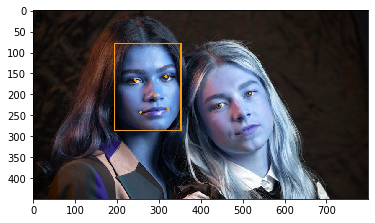

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(placeholder)
plt.imshow(img)
plt.show()

As you can see above, the results is a list of bounding boxes, where each bounding box defines a lower-left-corner of the bounding box, as well as the width and height.

If we assume that there is only **one** face in the photo, we can then determine the pixcel coordinates of the bounding box. The library might return a negative pixel index, that can be fixed by taking the absolute value of the coordinates.

In [39]:
#extract the bounding box from the first face
x1, y1, width, height = results[0]['box']
#bug fix (abs() = returns absolute value)
x1, y1 = abs(x1), abs(y1)
x2, y2 = x1 + width, y1 + height

In [40]:
#extract the face
face = image_array[y1:y2, x1:x2]

Then using the PIL library we can resise the image of the face to the required size (160x160)

In [41]:
#resise to the model size
image = Image.fromarray(face)
image = image.resize((160,160))
face_array = asarray(image)

In [42]:
face_array

array([[[42, 42, 76],
        [33, 33, 67],
        [41, 42, 73],
        ...,
        [29, 32, 39],
        [42, 47, 53],
        [33, 38, 44]],

       [[29, 32, 63],
        [31, 34, 65],
        [47, 51, 80],
        ...,
        [36, 36, 38],
        [31, 32, 36],
        [42, 43, 47]],

       [[30, 35, 65],
        [45, 50, 80],
        [50, 54, 83],
        ...,
        [43, 43, 43],
        [47, 47, 49],
        [38, 39, 43]],

       ...,

       [[26, 16, 15],
        [14,  5,  6],
        [ 7,  1,  1],
        ...,
        [73, 49, 37],
        [64, 40, 28],
        [81, 58, 42]],

       [[34, 22, 22],
        [24, 16, 14],
        [ 8,  2,  2],
        ...,
        [59, 36, 22],
        [79, 56, 42],
        [90, 64, 51]],

       [[47, 35, 35],
        [36, 26, 25],
        [ 9,  3,  3],
        ...,
        [68, 42, 29],
        [83, 57, 44],
        [92, 66, 53]]], dtype=uint8)

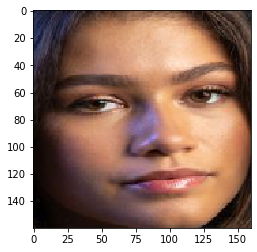

In [43]:
face_array_img = Image.fromarray(face_array, 'RGB')
#face_array_img.save('maybe_a_face.jpg')
plt.imshow(face_array_img)
plt.show()

Packing everything into a function:

In [90]:
from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN

def extract_face(filename, required_size=(160,160)):
    image = Image.open(filename)
    image = image.convert('RGB')
    pixels = asarray(image)
    detector = MTCNN()
    results = detector.detect_faces(pixels)
    x1, y1, width, height = results[0]['box']
    #bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    face = pixels[y1:y2, x1:x2]
    #resise to model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    return face_array

#load the photo and extract the face
pixels = extract_face('test.jpg')

## Developing a Face Classification System

* Will be using the 5 Celebrity Faces Dataset (https://www.kaggle.com/dansbecker/5-celebrity-faces-dataset)

Using the face detector function to detect the face in each photo and reduce the dataset to a series of faces only:

In [91]:
from os import listdir
from matplotlib import pyplot

1 (160, 160, 3)
2 (160, 160, 3)
3 (160, 160, 3)
4 (160, 160, 3)
5 (160, 160, 3)
6 (160, 160, 3)
7 (160, 160, 3)
8 (160, 160, 3)


KeyboardInterrupt: 

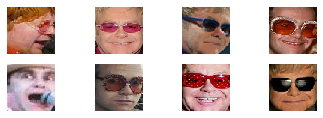

In [98]:
#specify folder to plot
folder = 'data/train/elton_john/'
i = 1
#enumerate files
for filename in listdir(folder):
    path = folder + filename
    face = extract_face(path)
    print(i, face.shape)
    #plot
    pyplot.subplot(4, 4, i)
    pyplot.axis('off')
    pyplot.imshow(face)
    i += 1
pyplot.show()

It can be expanded to step over each subdir for a given dataset (in this case 'train' or 'val'), extract the faces, and prepare a dataset iwth the name as the output label for each detected face

Therefore, the function below will load all faces into a list for a given dir:

In [33]:
def load_faces(directory):
    faces = list()
    #enumerate
    for filename in listdir(directory):
        path = directory + filename
        face = extract_face(path)
        faces.append(face)
    return faces

In [43]:
load_faces('data/train/elton_john/')

[array([[[131,  72,   2],
         [131,  72,   2],
         [131,  72,   2],
         ...,
         [ 99,  38,   0],
         [ 99,  38,   0],
         [ 99,  38,   0]],
 
        [[131,  72,   2],
         [131,  72,   2],
         [131,  72,   2],
         ...,
         [ 99,  38,   0],
         [ 99,  38,   0],
         [ 99,  38,   0]],
 
        [[117,  58,   0],
         [117,  58,   0],
         [117,  58,   0],
         ...,
         [105,  44,   0],
         [105,  44,   0],
         [105,  44,   0]],
 
        ...,
 
        [[180,  41,  10],
         [180,  41,  10],
         [180,  41,  10],
         ...,
         [ 39,  39,  31],
         [ 39,  39,  31],
         [ 39,  39,  31]],
 
        [[181,  37,  10],
         [181,  37,  10],
         [181,  37,  10],
         ...,
         [ 22,  23,  17],
         [ 22,  23,  17],
         [ 22,  23,  17]],
 
        [[181,  37,  10],
         [181,  37,  10],
         [181,  37,  10],
         ...,
         [ 22,  23,  17],
  

We can conclude that this function takes a directory name such as 'data/train/' and detect faces for each subdirectory (celebrity) assigning labels to each detected face.

It then returns the X and Y elements of the dataset as NumPy arrays.

The function below allows to load a dataset that contains one subdir for each class that in turn contains images:

In [44]:
def load_dataset(directory):
    X, y = list(), list()
    #enumerate folders, one per class
    for subdir in listdir(directory):
        path = directory + subdir + '/'
        #skip any files that might be in the dir
        if not isdir(path):
            continue
        faces = load_faces(path)
        #create labels
        labels = [subdir for _ in range(len(faces))]
        #summarise progress
        print('>loaded %d examples for class: %s' % (len(faces), subdir))
        #store
        X.extend(faces)
        y.extend(labels)
    return asarray(X), asarray(y)

This function can be called for the 'train' and 'val' folder to load all the data, then save the results in a single compressed NumPy array file using savez_compressed()

In [48]:
from os import listdir
from os.path import isdir
from numpy import savez_compressed
#load train dataset
trainX, trainy = load_dataset('data/train/')
print(trainX.shape, trainy.shape)
#load test dataset
testX, testy = load_dataset('data/val/')
print(testX.shape, testy.shape)
#save
savez_compressed('compressed_data.npz', trainX, trainy, testX, testy)

>loaded 14 examples for class: ben_afflek
>loaded 19 examples for class: madonna
>loaded 16 examples for class: elton_john
>loaded 22 examples for class: mindy_kaling
>loaded 21 examples for class: jerry_seinfeld
(92, 160, 160, 3) (92,)
>loaded 5 examples for class: ben_afflek
>loaded 5 examples for class: madonna
>loaded 5 examples for class: elton_john
>loaded 5 examples for class: mindy_kaling
>loaded 5 examples for class: jerry_seinfeld
(25, 160, 160, 3) (25,)
